In [55]:
import pandas as pd
import numpy as np
import itertools
from sklearn.isotonic import IsotonicRegression


data = pd.read_csv('data/2015.csv')
def convert_cats(cat):
    if cat in ['Green Side Bunker','Fairway Bunker']:
        return 'Bunker'
    elif cat not in ['Green','Fairway','Fringe','Primary Rough','Intermediate Rough','Tee Box']:
        return 'Other'
    else:
        return cat

if 'Cat' in data.columns:
    data = data.drop('Cat',axis=1)
data.insert(len(data.columns),'Cat',[convert_cats(c) for c in data['From_Location(Scorer)'].tolist()])


uCRHtps = list(itertools.product(pd.unique(data['Course_#']),pd.unique(data.Round),pd.unique(data.Hole)))

data = data[['Course_#','Round','Hole','Player_#','Hole_Score','Shot','Cat','Shots_taken_from_location',
            'Distance_from_hole','Started_at_X','Started_at_Y','Went_to_X','Went_to_Y','Started_at_Z','Went_to_Z']].values



errors = []
strokes_gained_per_cat = {'Bunker':[],'Other':[],'Green':[],'Fairway':[],'Fringe':[],'Primary Rough':[],
                            'Intermediate Rough':[], 'Tee Box':[]}
strokes_gained_putts = {'Uphill':[],'Downhill':[]}

for crhtup in uCRHtps[0:300]:
    subset = data[np.where((data[:,0]==crhtup[0]) & (data[:,1]==crhtup[1]) & (data[:,2]==crhtup[2]))]
    if subset.shape[0]<50:
        continue
    players = pd.unique(subset[:,3])
    scores = {player:int(subset[np.where(subset[:,3]==player)][0,4]) for player in players}
    ave_score = np.mean(np.array([scores.get(player) for player in players]))

    for player in players:
        sub = subset[np.where(subset[:,3]!=player)]
        model = IsotonicRegression(out_of_bounds='clip')
        model.fit(sub[:,8],sub[:,7])

        tot_strokes_gained = ave_score - scores[player]

        model_predicted_strokes_gained = 0

        sub = subset[np.where(subset[:,3]==player)]

        for row_ind in range(2,scores[player]+1):
            if row_ind==2:
                model_predicted_strokes_gained += ave_score - model.predict([sub[np.where(sub[:,5]==row_ind)][0,8]])[0] - 1
                strokes_gained_per_cat[sub[np.where(sub[:,5]==row_ind-1)][0,6]].append(ave_score - model.predict([sub[np.where(sub[:,5]==row_ind)][0,8]])[0] - 1)
            else:
                model_predicted_strokes_gained += model.predict([sub[np.where(sub[:,5]==row_ind-1)][0,8]])[0] - model.predict([sub[np.where(sub[:,5]==row_ind)][0,8]])[0] - 1
                strokes_gained_per_cat[sub[np.where(sub[:,5]==row_ind-1)][0,6]].append(model.predict([sub[np.where(sub[:,5]==row_ind-1)][0,8]])[0] - model.predict([sub[np.where(sub[:,5]==row_ind)][0,8]])[0] - 1)
                if sub[np.where(sub[:,5]==row_ind-1)][0,6]=='Green':
                    if sub[np.where(sub[:,5]==row_ind-1)][0,14] - sub[np.where(sub[:,5]==row_ind-1)][0,13] > 0:
                        strokes_gained_putts['Uphill'].append(model.predict([sub[np.where(sub[:,5]==row_ind-1)][0,8]])[0] - model.predict([sub[np.where(sub[:,5]==row_ind)][0,8]])[0] - 1)
                    else:
                        strokes_gained_putts['Downhill'].append(model.predict([sub[np.where(sub[:,5]==row_ind-1)][0,8]])[0] - model.predict([sub[np.where(sub[:,5]==row_ind)][0,8]])[0] - 1)
        model_predicted_strokes_gained += model.predict([sub[np.where(sub[:,5]==scores[player])][0,8]])[0] - 1
        strokes_gained_per_cat[sub[np.where(sub[:,5]==scores[player])][0,6]].append(model.predict([sub[np.where(sub[:,5]==scores[player])][0,8]])[0] - 1)
        if sub[np.where(sub[:,5]==scores[player])][0,6]=='Green':
            if sub[np.where(sub[:,5]==scores[player])][0,14] - sub[np.where(sub[:,5]==scores[player])][0,13] > 0:
                strokes_gained_putts['Uphill'].append(model.predict([sub[np.where(sub[:,5]==scores[player])][0,8]])[0] - 1)
            else:
                strokes_gained_putts['Downhill'].append(model.predict([sub[np.where(sub[:,5]==scores[player])][0,8]])[0] - 1)
                
    errors.append((model_predicted_strokes_gained - tot_strokes_gained))


print pd.Series(errors).describe()
for cat in strokes_gained_per_cat:
    print cat, pd.Series(strokes_gained_per_cat[cat]).describe()
for slope in strokes_gained_putts:
    print slope, pd.Series(strokes_gained_putts[slope]).describe()

count    2.970000e+02
mean     1.495250e-18
std      3.023036e-17
min     -1.110223e-16
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.440892e-16
dtype: float64
Primary Rough count    9342.000000
mean       -0.133564
std         0.406089
min        -1.887865
25%        -0.395547
50%        -0.130435
75%         0.090909
max         1.961988
dtype: float64
Intermediate Rough count    2822.000000
mean       -0.004741
std         0.378179
min        -1.415584
25%        -0.222222
50%        -0.021463
75%         0.177596
max         2.000000
dtype: float64
Other count    684.000000
mean      -0.304710
std        0.456497
min       -1.540075
25%       -0.595333
50%       -0.305733
75%       -0.038062
max        2.048066
dtype: float64
Green count    46913.000000
mean         0.016909
std          0.337444
min         -1.333333
25%         -0.054054
50%          0.000000
75%          0.083333
max          1.977401
dtype: float64
Fairway count    18909.000000
me

In [4]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

In [25]:
from scipy.stats import probplot
import scipy.stats

((array([-1.43017034, -1.36241765, -1.32553687, ...,  1.35592799,
          1.39280877,  1.46056145]),
  array([-1.625     , -1.61007463, -1.375     , ...,  1.70833333,
          1.75      ,  1.97740113])),
 (0.94315565560002335, 0.00086378158004732711, 0.94310378716969379))

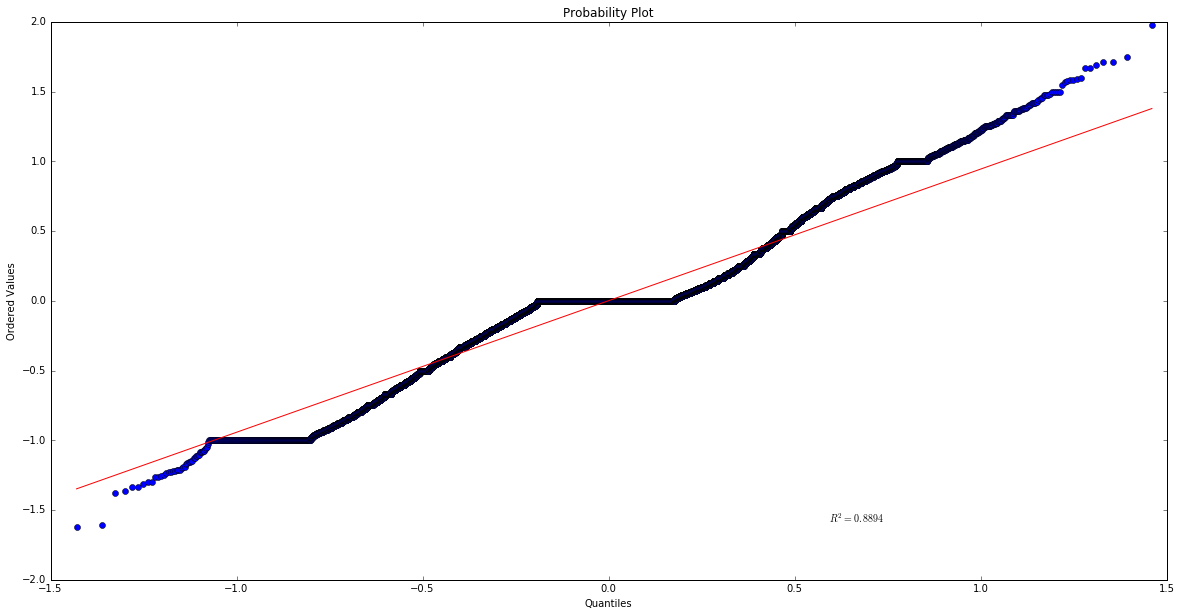

In [20]:
fig,ax = plt.subplots(figsize=(20, 10))
probplot(strokes_gained_per_cat['Green'],(np.mean(strokes_gained_per_cat['Green']), np.std(strokes_gained_per_cat['Green'])),plot=plt)

In [26]:
rv = scipy.stats.laplace(loc=np.mean(strokes_gained_per_cat['Green']), scale=(np.var(strokes_gained_per_cat['Green'])/2)**.5)

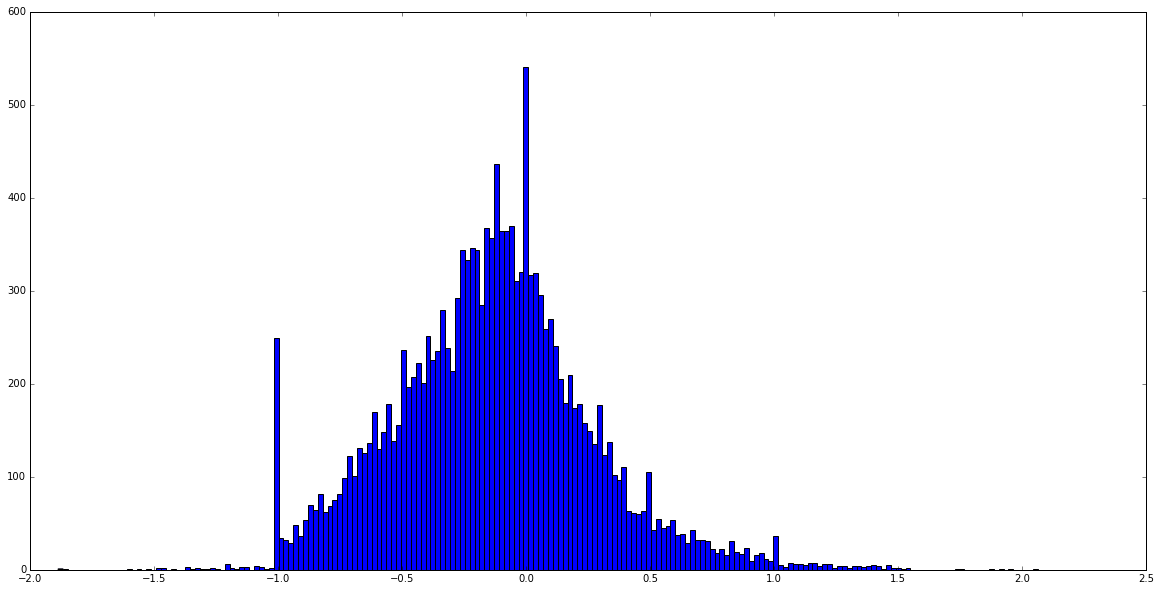

In [39]:
fig,ax = plt.subplots(figsize=(20, 10))
plt.hist(strokes_gained_per_cat['Primary Rough'],bins=200)
x = np.linspace(min(strokes_gained_per_cat['Primary Rough']),max(strokes_gained_per_cat['Primary Rough']),len(strokes_gained_per_cat['Primary Rough']))
#plt.plot(x,10000*rv.pdf(x))

In [42]:
def hypo_test_above_below_zero(sample,its):
    above_0,below_0 = 0,0
    for _ in xrange(its):
        samp = np.random.choice(sample,len(sample))
        if np.mean(samp)>0:
            above_0 +=1
        else:
            below_0 +=1
    return above_0/float(its) - below_0/float(its)

In [49]:
hypo_test_above_below_zero(strokes_gained_per_cat['Bunker'],10000)

-1.0

In [67]:
def hypo_test_difference_of_two_means_one_sided(sample_b,sample_s,its):
    test_stat = np.mean(sample_b) - np.mean(sample_s)
    haps = 0
    for _ in xrange(its):
        pooled_sample = sample_b + sample_s
        np.random.shuffle(pooled_sample)
        if np.mean(pooled_sample[:len(sample_b)])-np.mean(pooled_sample[len(sample_b):]) >= test_stat:
            haps += 1
    return haps/float(its)

In [68]:
hypo_test_difference_of_two_means_one_sided(strokes_gained_putts['Uphill'],strokes_gained_putts['Downhill'],10000)

0.0